In [13]:

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, \
    KNNWithZScore, BaselineOnly, CoClustering, accuracy
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
init_notebook_mode(connected=True)

import numpy as np
import pandas as pd
import csv

# Reading the user-task dataset
columns = ['id','LocationsOfInterest','TaskId','rating']
frame = pd.read_csv('DataRecommenderSystem/DataInterviewVisitor.csv',sep=',', names=columns)
frame.head()

,id,LocationsOfInterest,TaskId,rating
0,0,11010,1,7
1,1,10010,2,7
2,2,11010,3,8
3,3,1000,4,7
4,4,10000,5,6


In [14]:
# Reading the task dataset
columns2 =['TaskId','TaskName','LocationsOfInterest']
tasks = pd.read_csv('DataRecommenderSystem/TasksInterviewVisitor.csv', sep=',', names = columns2, encoding='latin-1')
task_names = tasks[['TaskId','TaskName','LocationsOfInterest']]
task_names.head()

# Distribution of task-ratings
data = frame['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / frame.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Interview Task-ratings'.format(frame.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [15]:
combined_task_data = pd.merge(frame, task_names, on='TaskId')
combined_task_data.head()

,id,LocationsOfInterest_x,TaskId,rating,TaskName,LocationsOfInterest_y
0,0,11010,1,7,Task1,11010
1,6,11010,1,9,Task1,11010
2,7,11010,1,7,Task1,11010
3,19,11010,1,10,Task1,11010
4,22,11010,1,4,Task1,11010


In [16]:
combined_task_data.groupby('TaskId')['rating'].count().sort_values(ascending=True).head()

filter_interview = combined_task_data['TaskId']==0
combined_task_data[filter_interview]['TaskName'].unique()

# Distribution of Number of Ratings per task
# Create trace
trace = go.Histogram(x = combined_task_data.TaskId,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Interview Task',
                   xaxis = dict(title = 'Number of Ratings Per Task'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# Distribution of Number of Ratings per user
# Create trace
trace = go.Histogram(x = combined_task_data.id,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 1000,
                                  size = 100))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Interview Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [17]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(combined_task_data[['id', 'TaskId', 'rating']], reader)


import surprise
from surprise import SVD
from surprise import Dataset
from surprise import accuracy

# Recommendation using SVD++
lower_rating = frame['rating'].min()
upper_rating = frame['rating'].max()

alg=surprise.SVDpp()
output=alg.fit(data.build_full_trainset())

pred = alg.predict(uid=0,iid=1)
score = pred.est


iids = frame['TaskId'].unique()
iids0 = frame.loc[frame['id']==0,'TaskId']

iids_to_pred = np.setdiff1d(iids,iids0)

testset = [[0,iid,3.] for iid in iids_to_pred]
predictions = alg.test(testset)

# Top three rated tasks
pred_ratings = np.array([pred.est for pred in predictions])
i_max = np.argpartition(pred_ratings, -3)[-3:]

iid = iids_to_pred[i_max[0]]
iid2=iids_to_pred[i_max[1]]
iid3=iids_to_pred[i_max[2]]

filter1 = tasks.loc[tasks['TaskId']==iid]
filter1task = filter1['LocationsOfInterest'].tolist()

filter2 = tasks.loc[tasks['TaskId']==iid2]
filter2task = filter2['LocationsOfInterest'].tolist()

filter3 = tasks.loc[tasks['TaskId']==iid3]
filter3task = filter3['LocationsOfInterest'].tolist()

print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid,pred_ratings[i_max[0]]))
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid2,pred_ratings[i_max[1]]))
print('Top item for user 50 has TaskId {0} with pred rating {1}'.format(iid3,pred_ratings[i_max[2]]))

# Writing top three recommendations' task id in a csv file
with open('DataRecommenderSystem/recommenderSystemInterview.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(list([filter1task[0],filter2task[0],filter3task[0]]))


Top item for user 50 has TaskId 10 with pred rating 5.657777737098094
Top item for user 50 has TaskId 5 with pred rating 5.749816666812329
Top item for user 50 has TaskId 4 with pred rating 5.871490283142406


In [18]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
smt = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
print(smt)
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, cv=5, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

{'test_rmse': array([3.03557749, 3.18581022, 3.08245015, 3.28386952, 3.27251049]),
 'test_mae': array([2.60226955, 2.72670314, 2.71420741, 2.8528332 , 2.8381734 ]),
 'fit_time': (0.005001544952392578,
  0.003996133804321289,
  0.0039958953857421875,
  0.004000663757324219,
  0.003999948501586914),
 'test_time': (0.0019965171813964844,
  0.0020003318786621094,
  0.0019991397857666016,
  0.002000570297241211,
  0.001999378204345703)}

In [19]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 3.1088


3.108791504438089

In [20]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print(best_predictions)
print(worst_predictions)

     uid  iid  rui       est                    details  Iu   Ui       err
163   30    5  5.0  4.884680  {'was_impossible': False}   0   64  0.115320
44   699    5  5.0  4.884680  {'was_impossible': False}   0   64  0.115320
216  111    2  5.0  5.141314  {'was_impossible': False}   0  129  0.141314
135  858    2  5.0  5.141314  {'was_impossible': False}   0  129  0.141314
107  444    3  5.0  4.736834  {'was_impossible': False}   0   82  0.263166
123  282    1  5.0  5.365013  {'was_impossible': False}   0  211  0.365013
211   73    1  5.0  5.365013  {'was_impossible': False}   0  211  0.365013
162  784    1  5.0  5.365013  {'was_impossible': False}   0  211  0.365013
184  295    1  5.0  5.365013  {'was_impossible': False}   0  211  0.365013
181  906    1  5.0  5.365013  {'was_impossible': False}   0  211  0.365013
     uid  iid   rui       est                    details  Iu   Ui       err
89   815    3  10.0  4.736834  {'was_impossible': False}   0   82  5.263166
210  256    1   0.0  5.

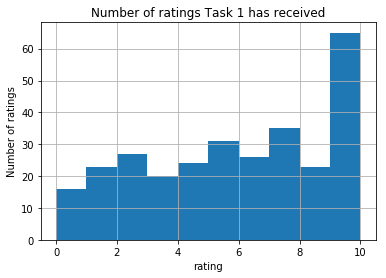

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
combined_task_data.loc[combined_task_data['TaskId'] == 1]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Task 1 has received')
plt.show();


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

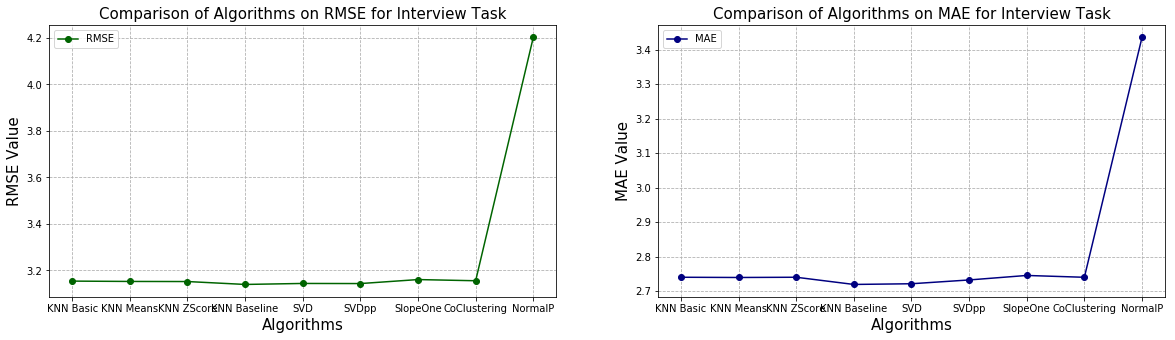

,id,LocationsOfInterest,TaskId,rating
count,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,499.500000,5.936050e+04,3.810000,5.228000
std,288.819436,2.161298e+05,2.800311,3.161014
min,0.000000,1.000000e+03,1.000000,0.000000
25%,249.750000,1.001000e+04,1.000000,2.000000
50%,499.500000,1.101000e+04,3.000000,5.000000
75%,749.250000,1.101000e+04,6.000000,8.000000
max,999.000000,1.111110e+06,11.000000,10.000000


In [22]:
# SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()
knnbasic_cv = cross_validate(KNNBasic(), data, cv=5, verbose=False)
knnmeans_cv = cross_validate(KNNWithMeans(), data, cv=5, verbose=False)
knnz_cv = cross_validate(KNNWithZScore(), data, cv=5, verbose=False)
svd_cv = cross_validate(SVD(), data, cv=5, verbose=False)
svdpp_cv = cross_validate(SVDpp(), data, cv=5, verbose=False)
#nmf_cv = cross_validate(NMF(), data, cv=5, n_jobs=5, verbose=False)
slope_cv = cross_validate(SlopeOne(), data, cv=5, verbose=False)
coclus_cv = cross_validate(CoClustering(), data, cv=5, verbose=False)
normalPredictor_cv= cross_validate(NormalPredictor(),data, cv=5, verbose=False)
knnBaseline_cv = cross_validate(KNNBaseline(), data, cv=5, verbose=False)

# Comparing Algorithms using RMSE and MAE
print('Algorithm\t RMSE\t\t MAE')
print()
print('KNN Basic', '\t', round(knnbasic_cv['test_rmse'].mean(), 6), '\t', round(knnbasic_cv['test_mae'].mean(), 6))
print('KNN Means', '\t', round(knnmeans_cv['test_rmse'].mean(), 6), '\t', round(knnmeans_cv['test_mae'].mean(), 6))
print('KNN ZScore', '\t', round(knnz_cv['test_rmse'].mean(), 6), '\t', round(knnz_cv['test_mae'].mean(), 6))
print('KNN Baseline', '\t', round(knnBaseline_cv['test_rmse'].mean(), 6), '\t', round(knnBaseline_cv['test_mae'].mean(), 6))
print()
print('SVD', '\t\t', round(svd_cv['test_rmse'].mean(), 6), '\t', round(svd_cv['test_mae'].mean(), 6))
print('SVDpp', '\t\t', round(svdpp_cv['test_rmse'].mean(), 6), '\t', round(svdpp_cv['test_mae'].mean(), 6))
#print('NMF', '\t\t', round(nmf_cv['test_rmse'].mean(), 4), '\t', round(nmf_cv['test_mae'].mean(), 4))
print()
print('SlopeOne', '\t', round(slope_cv['test_rmse'].mean(), 6), '\t', round(slope_cv['test_mae'].mean(), 6))
print('CoClustering', '\t', round(coclus_cv['test_rmse'].mean(), 6), '\t', round(coclus_cv['test_mae'].mean(), 6))
print()
print('NormalPred', '\t', round(normalPredictor_cv['test_rmse'].mean(), 6), '\t', round(normalPredictor_cv['test_mae'].mean(), 6))
print()

x_algo = ['KNN Basic', 'KNN Means', 'KNN ZScore', 'KNN Baseline', 'SVD', 'SVDpp', 'SlopeOne', 'CoClustering', 'NormalP']
all_algos_cv = [knnbasic_cv, knnmeans_cv, knnz_cv, knnBaseline_cv, svd_cv, svdpp_cv, slope_cv, coclus_cv, normalPredictor_cv]

rmse_cv = [round(res['test_rmse'].mean(), 6) for res in all_algos_cv]
mae_cv = [round(res['test_mae'].mean(), 6) for res in all_algos_cv]

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title('Comparison of Algorithms on RMSE for Interview Task', loc='center', fontsize=15)
plt.plot(x_algo, rmse_cv, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.subplot(1, 2, 2)
plt.title('Comparison of Algorithms on MAE for Interview Task', loc='center', fontsize=15)
plt.plot(x_algo, mae_cv, label='MAE', color='navy', marker='o')
plt.xlabel('Algorithms', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dashed')

plt.show()
frame.describe()

In [23]:
# Parameter space
svd_param_grid = {'n_epochs': [20, 25], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}

svdpp_gs = GridSearchCV(SVDpp, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svdpp_gs.fit(data)

svd_gs = GridSearchCV(SVD, svd_param_grid, measures=['rmse', 'mae'], cv=5)
svd_gs.fit(data)

print('SVDpp - RMSE:', round(svdpp_gs.best_score['rmse'], 6), '; MAE:', round(svdpp_gs.best_score['mae'], 6))
print('SVD   - RMSE:', round(svd_gs.best_score['rmse'], 6), '; MAE:', round(svd_gs.best_score['mae'], 6))
#SVDpp best params
print('RMSE =', svdpp_gs.best_params['rmse'])
print('MAE =', svdpp_gs.best_params['mae'])
#SVD best params
print('RMSE =', svd_gs.best_params['rmse'])
print('MAE =', svd_gs.best_params['mae'])



SVDpp - RMSE: 3.150711 ; MAE: 2.731737
SVD   - RMSE: 3.150425 ; MAE: 2.731407
RMSE = {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}
MAE = {'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.4}
RMSE = {'n_epochs': 25, 'lr_all': 0.002, 'reg_all': 0.6}
MAE = {'n_epochs': 25, 'lr_all': 0.002, 'reg_all': 0.6}


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

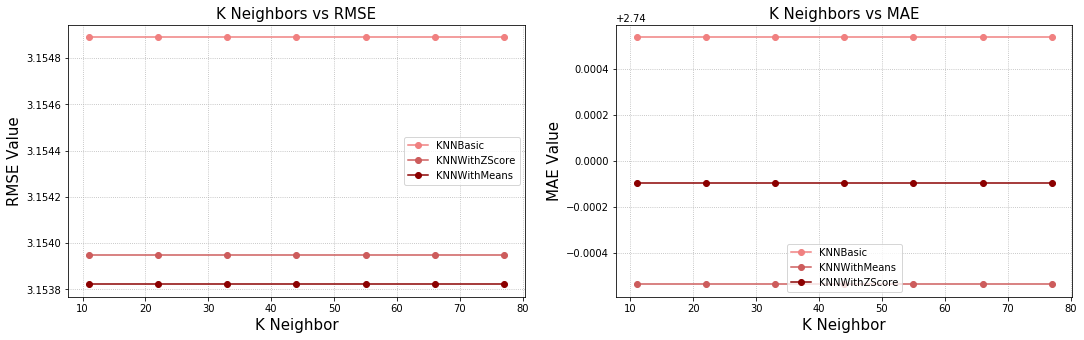

In [24]:
# Hyperparameter tuning for KNN algorithms
param_grid = {'k': [11, 22, 33, 44, 55, 66, 77]}

knnbasic_gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=5)
knnbasic_gs.fit(data)

knnmeans_gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse', 'mae'], cv=5)
knnmeans_gs.fit(data)

knnz_gs = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5)
knnz_gs.fit(data)

x = [11, 22, 33, 44, 55, 66, 77]
y1 = knnbasic_gs.cv_results['mean_test_rmse']
y2 = knnbasic_gs.cv_results['mean_test_mae']

y3 = knnmeans_gs.cv_results['mean_test_rmse']
y4 = knnmeans_gs.cv_results['mean_test_mae']

y5 = knnz_gs.cv_results['mean_test_rmse']
y6 = knnz_gs.cv_results['mean_test_mae']

plt.figure(figsize=(18,5))

plt.subplot(1, 2, 1)
plt.title('K Neighbors vs RMSE', loc='center', fontsize=15)
plt.plot(x, y1, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y5, label='KNNWithZScore', color='indianred', marker='o')
plt.plot(x, y3, label='KNNWithMeans', color='darkred', marker='o')

plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.subplot(1, 2, 2)
plt.title('K Neighbors vs MAE', loc='center', fontsize=15)
plt.plot(x, y2, label='KNNBasic', color='lightcoral', marker='o')
plt.plot(x, y4, label='KNNWithMeans', color='indianred', marker='o')
plt.plot(x, y6, label='KNNWithZScore', color='darkred', marker='o')
plt.xlabel('K Neighbor', fontsize=15)
plt.ylabel('MAE Value', fontsize=15)
plt.legend()
plt.grid(ls='dotted')

plt.show()